# Flight Booking Price Prediction(Machine Learning + Power Bi)

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import PartialDependenceDisplay
import shap
import joblib



In [2]:

# Step 2: Load Dataset
df = pd.read_csv(r'C:\Users\nikit\Downloads\flight_booking_dataa.csv')

# Drop unwanted columns
df.drop(columns=[col for col in ['Unnamed: 0', 'flight'] if col in df.columns], inplace=True)
df.head()



,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,travel_date,month,season,weekday/weekoff,is_holiday
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,2025-02-04,February,Winter,Weekday,No
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,2024-09-20,September,Autumn,Weekoff,Yes
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,2024-05-29,May,Spring,Midweek,No
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,2024-05-12,May,Spring,Weekday,No
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,2024-11-03,November,Autumn,Midweek,No


In [3]:
# Step 3: Initial Data Overview
print(df.info())
print(df.describe())
print("Missing values per column:\n", df.isnull().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   source_city       300153 non-null  object 
 2   departure_time    300153 non-null  object 
 3   stops             300153 non-null  object 
 4   arrival_time      300153 non-null  object 
 5   destination_city  300153 non-null  object 
 6   class             300153 non-null  object 
 7   duration          300153 non-null  float64
 8   days_left         300153 non-null  int64  
 9   price             300153 non-null  int64  
 10  travel_date       300153 non-null  object 
 11  month             300153 non-null  object 
 12  season            300153 non-null  object 
 13  weekday/weekoff   300153 non-null  object 
 14  is_holiday        300153 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 34.3+ MB
None
    

In [4]:
# Step 4: Map 'stops' to numeric and clean
stops_map = {'zero': 0, 'one': 1, 'two': 2}
df['stops'] = df['stops'].map(stops_map)
df = df[df['stops'].notna()]  # drop rows with unmapped stops if any
df['stops'] = df['stops'].astype(int)
df.head()



,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,travel_date,month,season,weekday/weekoff,is_holiday
0,SpiceJet,Delhi,Evening,0,Night,Mumbai,Economy,2.17,1,5953,2025-02-04,February,Winter,Weekday,No
1,SpiceJet,Delhi,Early_Morning,0,Morning,Mumbai,Economy,2.33,1,5953,2024-09-20,September,Autumn,Weekoff,Yes
2,AirAsia,Delhi,Early_Morning,0,Early_Morning,Mumbai,Economy,2.17,1,5956,2024-05-29,May,Spring,Midweek,No
3,Vistara,Delhi,Morning,0,Afternoon,Mumbai,Economy,2.25,1,5955,2024-05-12,May,Spring,Weekday,No
4,Vistara,Delhi,Morning,0,Morning,Mumbai,Economy,2.33,1,5955,2024-11-03,November,Autumn,Midweek,No


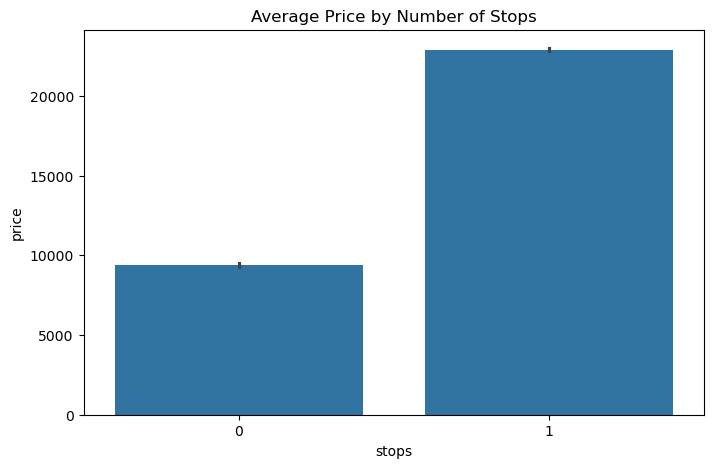

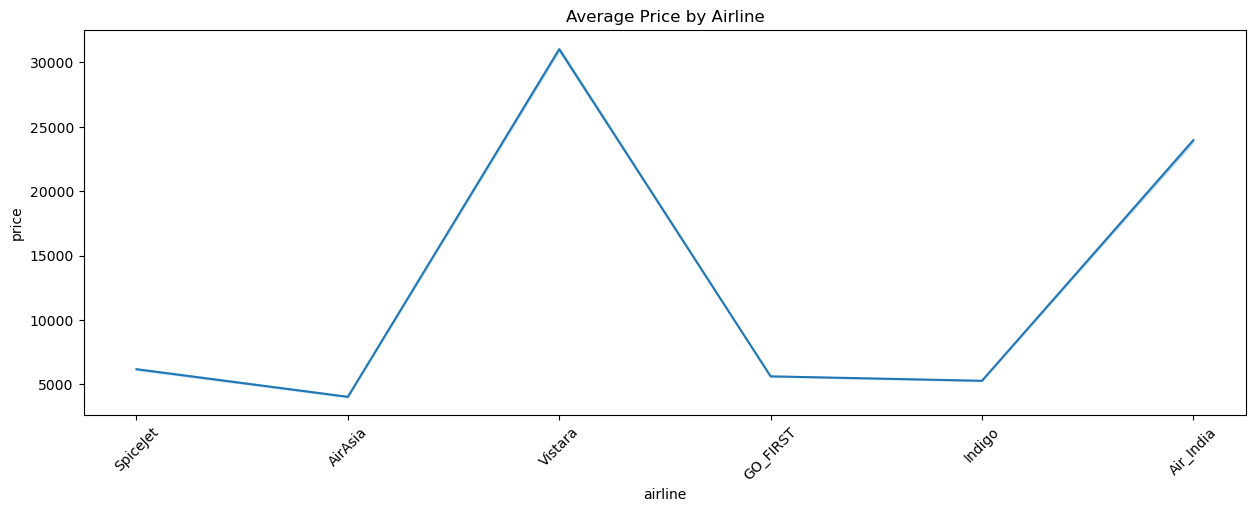

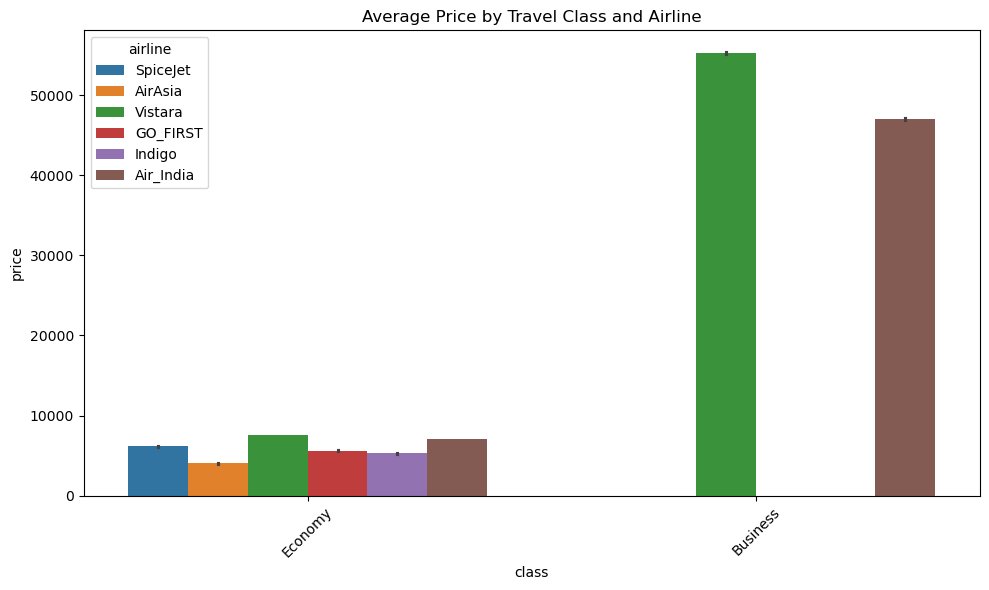

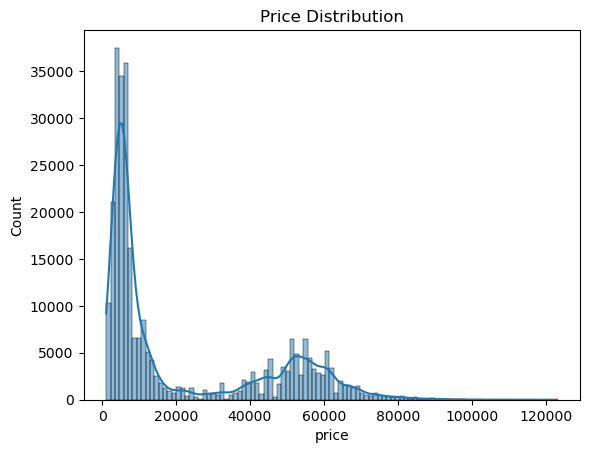

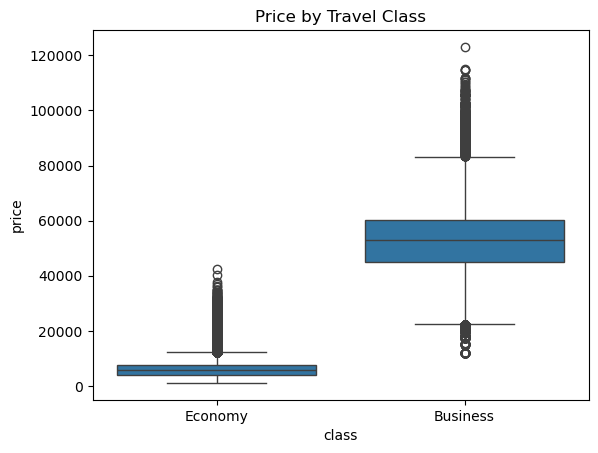

In [5]:
# Step 5: Key Visualizations
plt.figure(figsize=(8,5))
sns.barplot(x='stops', y='price', data=df, estimator=np.mean)
plt.title('Average Price by Number of Stops')
plt.show()

plt.figure(figsize=(15,5))
sns.lineplot(x='airline', y='price', data=df)
plt.title('Average Price by Airline')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='class', y='price', hue='airline', data=df, estimator=np.mean)
plt.title('Average Price by Travel Class and Airline')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sns.histplot(df['price'], kde=True)
plt.title("Price Distribution")
plt.show()

sns.boxplot(x='class', y='price', data=df)
plt.title("Price by Travel Class")
plt.show()



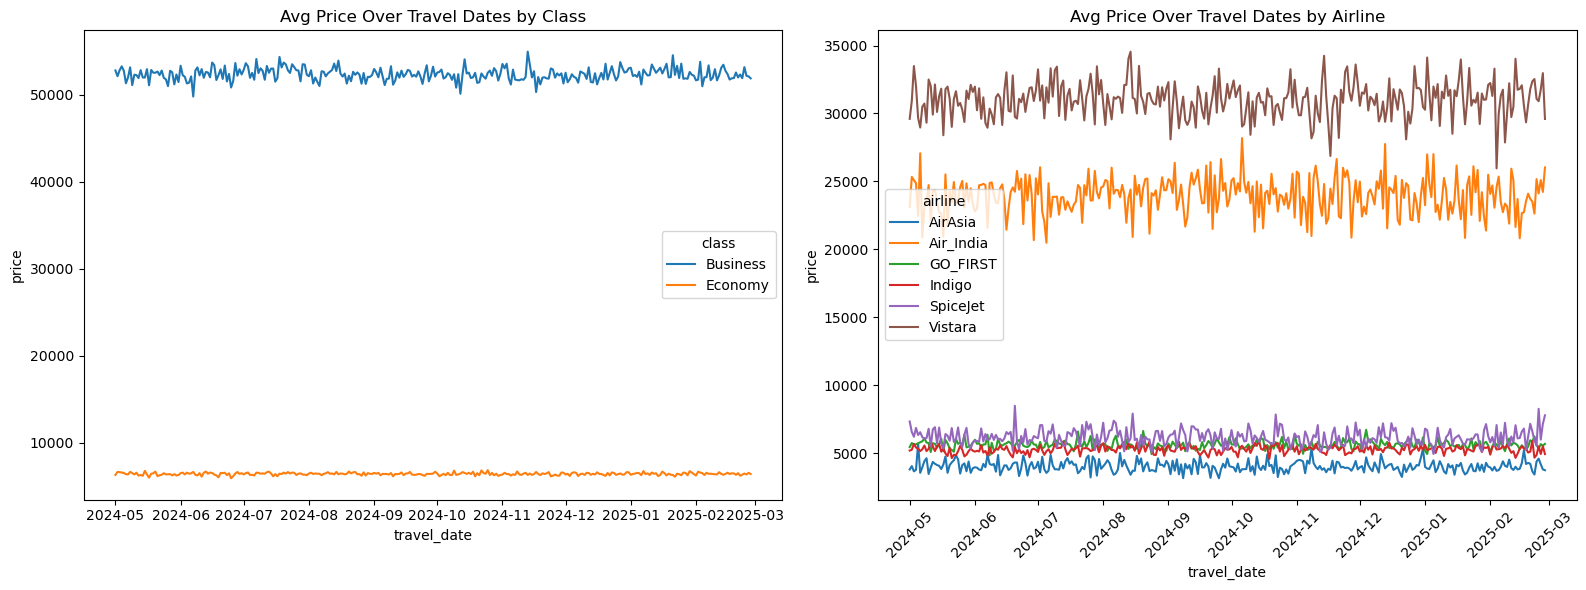

In [6]:
# Step 6: Date-based Price Trends
if 'travel_date' in df.columns:
    df['travel_date'] = pd.to_datetime(df['travel_date'], errors='coerce')
    df.dropna(subset=['travel_date'], inplace=True)

    price_by_class = df.groupby(['travel_date', 'class'])['price'].mean().reset_index()
    price_by_airline = df.groupby(['travel_date', 'airline'])['price'].mean().reset_index()

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.lineplot(data=price_by_class, x='travel_date', y='price', hue='class')
    plt.title('Avg Price Over Travel Dates by Class')

    plt.subplot(1, 2, 2)
    sns.lineplot(data=price_by_airline, x='travel_date', y='price', hue='airline')
    plt.title('Avg Price Over Travel Dates by Airline')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



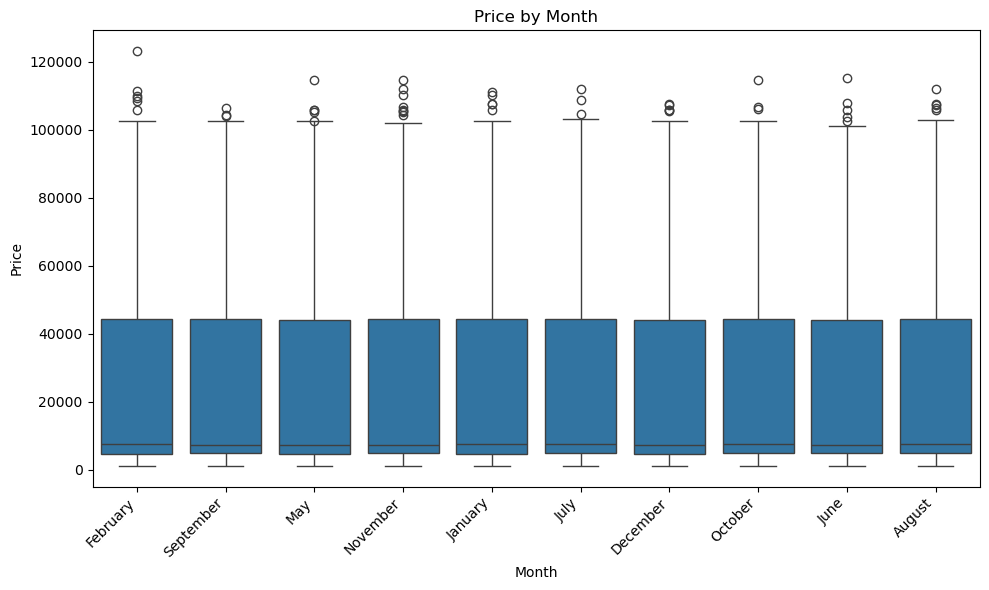

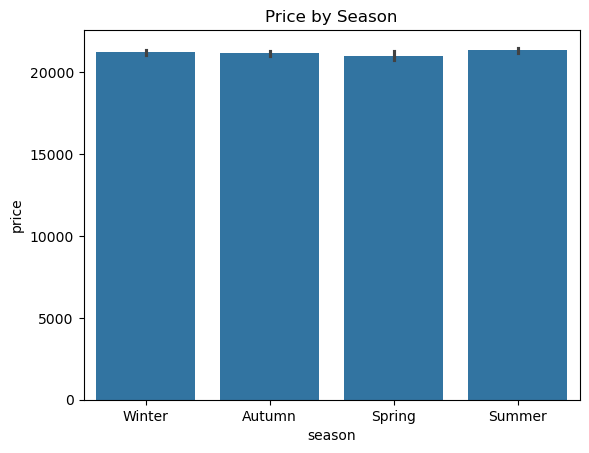

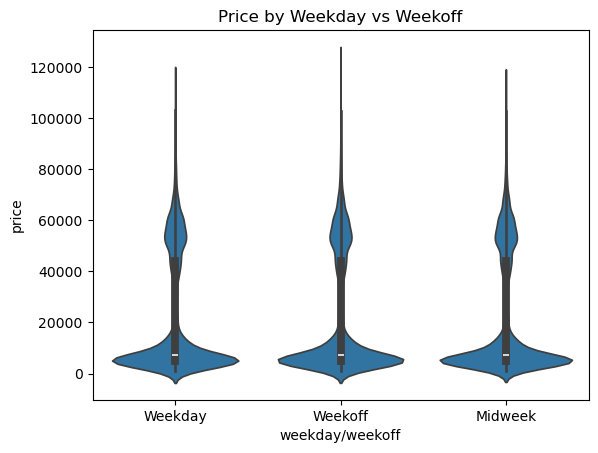

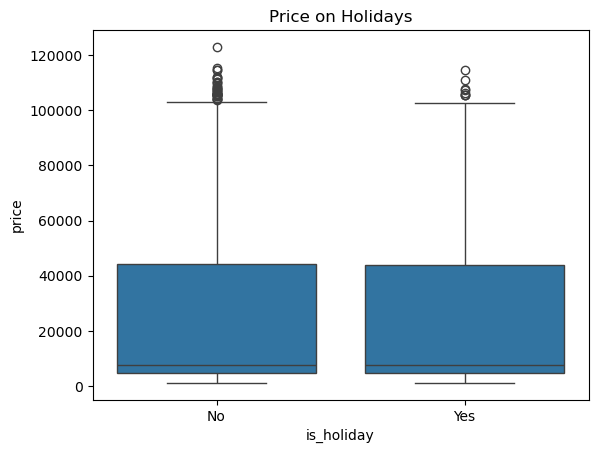

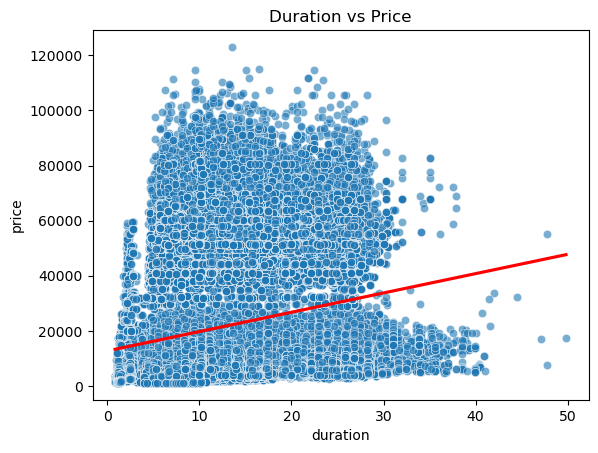

In [7]:
# Step 7: Other Visualizations
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='price', data=df)
plt.title("Price by Month")
plt.xlabel("Month")
plt.ylabel("Price")

# Rotate x-axis labels and space them out
plt.xticks(rotation=45, ha='right')  # rotate and align
plt.tight_layout()  # adjust spacing to avoid clipping
plt.show()

if 'season' in df.columns:
    sns.barplot(x='season', y='price', data=df)
    plt.title("Price by Season")
    plt.show()

if 'weekday/weekoff' in df.columns:
    sns.violinplot(x='weekday/weekoff', y='price', data=df)
    plt.title("Price by Weekday vs Weekoff")
    plt.show()

if 'is_holiday' in df.columns:
    sns.boxplot(x='is_holiday', y='price', data=df)
    plt.title("Price on Holidays")
    plt.show()

if 'duration' in df.columns:
    sns.scatterplot(x='duration', y='price', data=df, alpha=0.6)
    sns.regplot(x='duration', y='price', data=df, scatter=False, color='red')
    plt.title("Duration vs Price")
    plt.show()



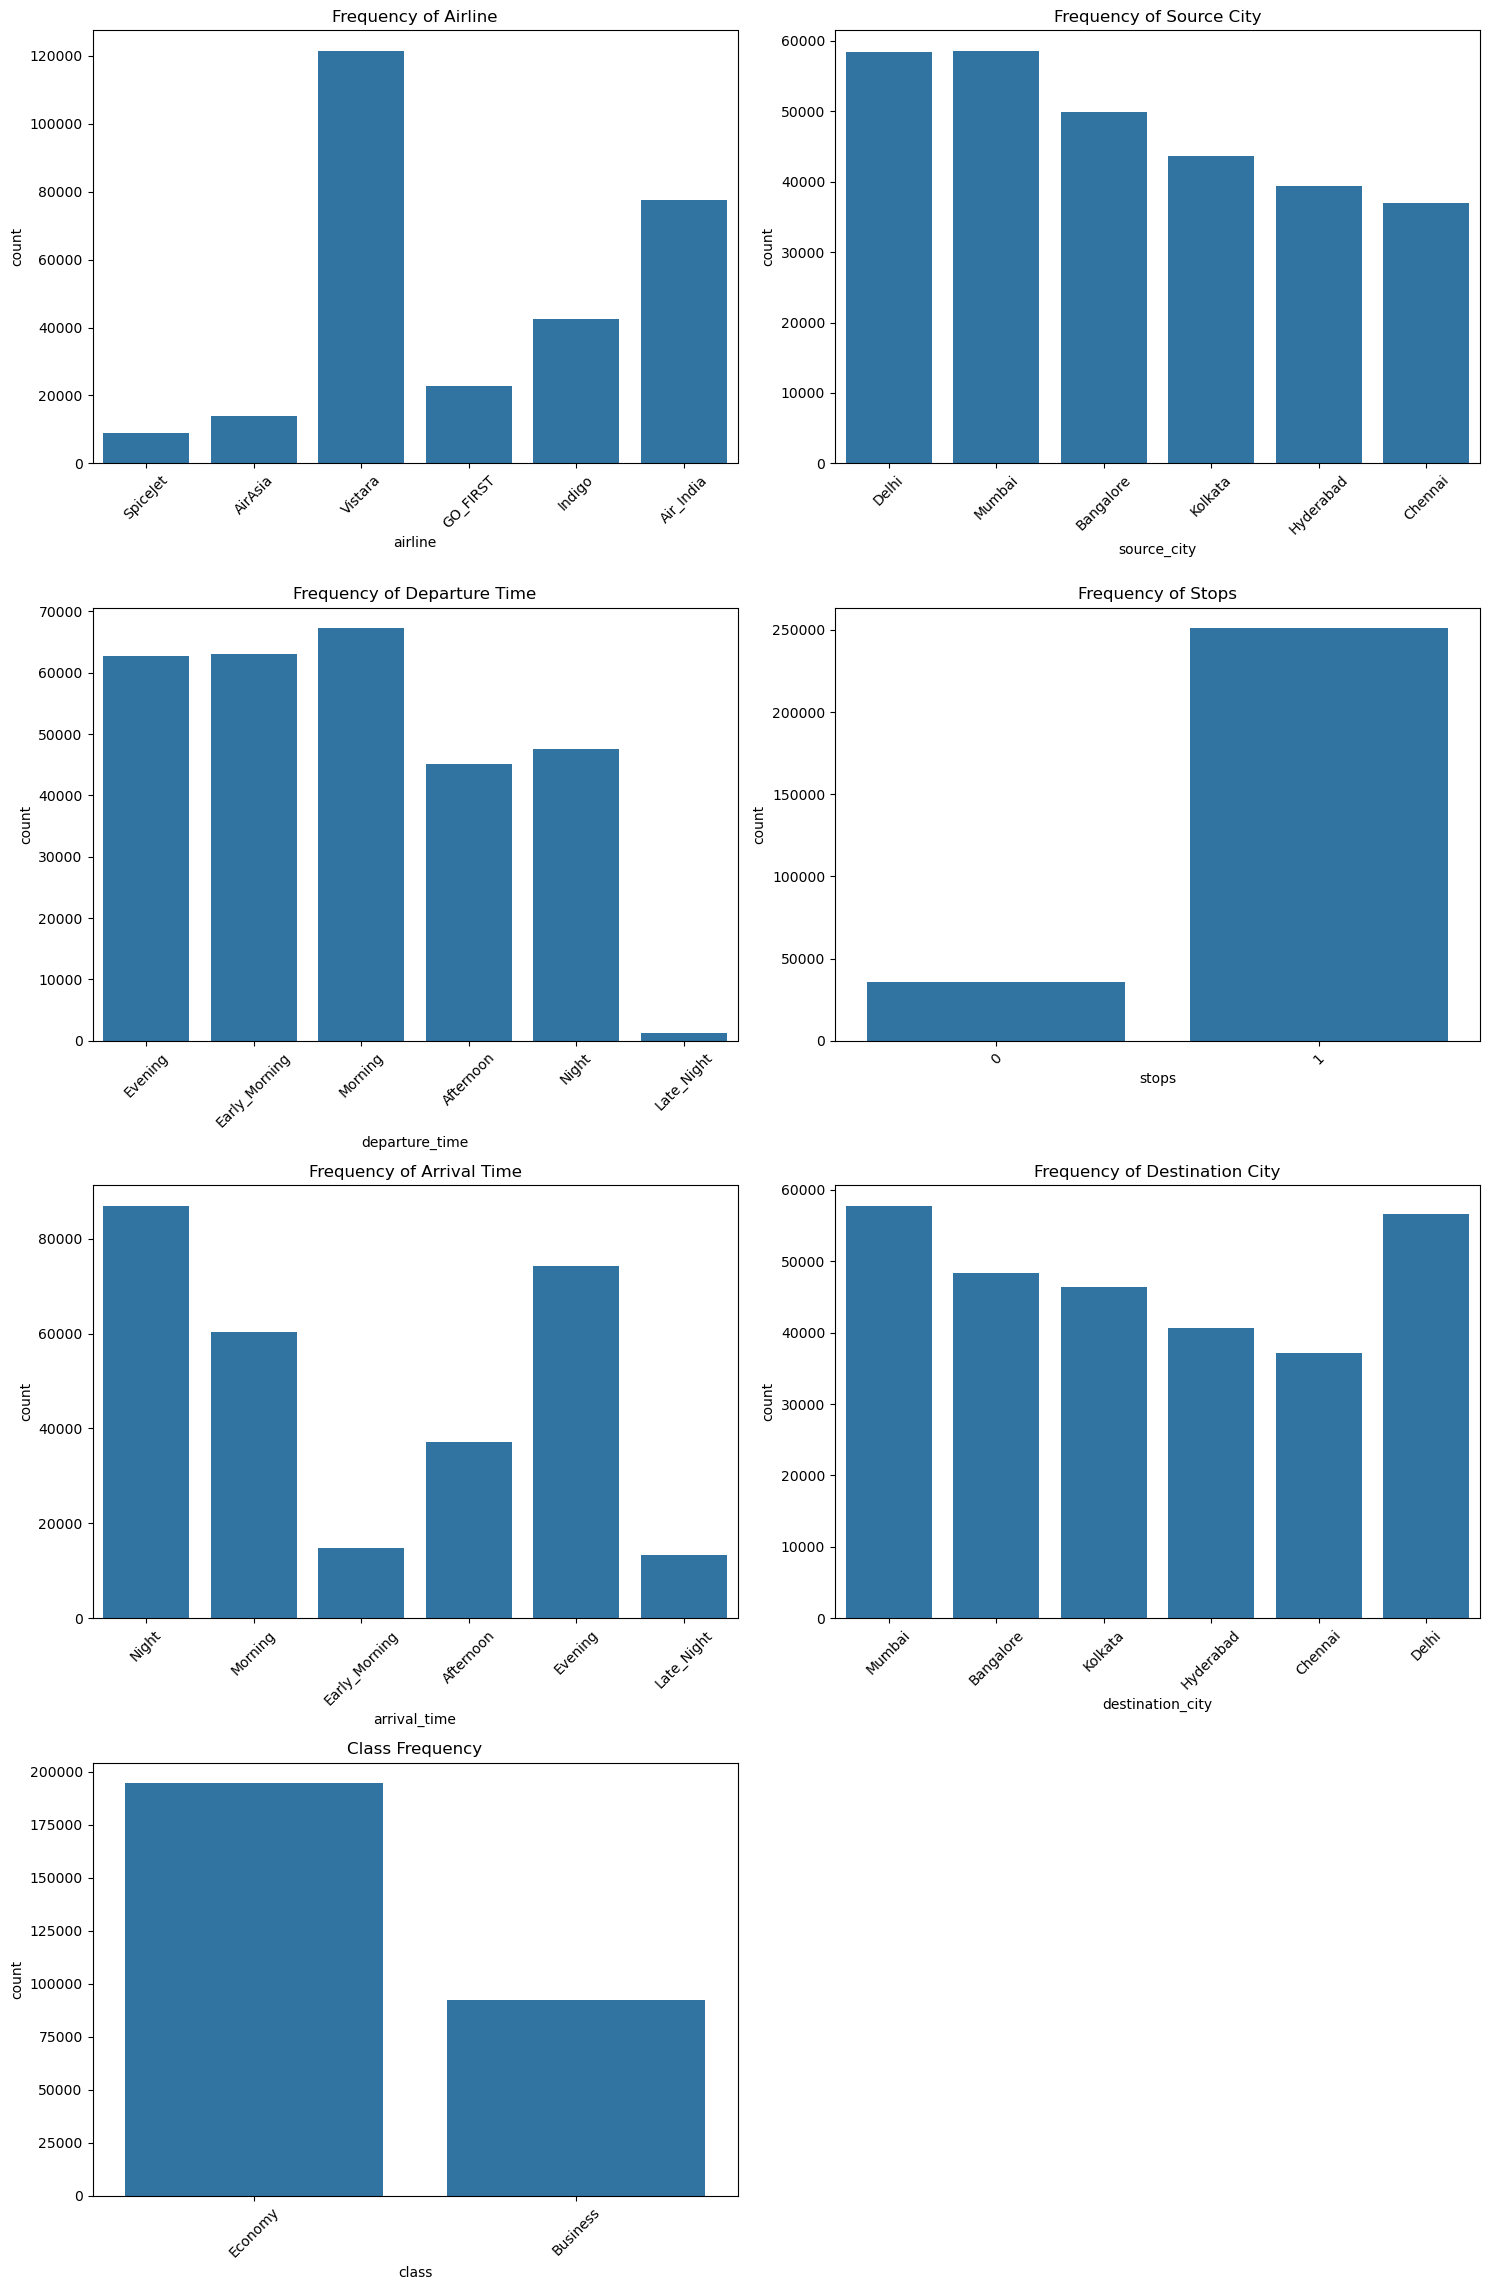

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 23))

plt.subplot(4, 2, 1)
sns.countplot(x="airline", data=df)
plt.title("Frequency of Airline")
plt.xticks(rotation=45)

plt.subplot(4, 2, 2)
sns.countplot(x="source_city", data=df)
plt.title("Frequency of Source City")
plt.xticks(rotation=45)

plt.subplot(4, 2, 3)
sns.countplot(x="departure_time", data=df)
plt.title("Frequency of Departure Time")
plt.xticks(rotation=45)

plt.subplot(4, 2, 4)
sns.countplot(x="stops", data=df)
plt.title("Frequency of Stops")
plt.xticks(rotation=45)

plt.subplot(4, 2, 5)
sns.countplot(x="arrival_time", data=df)
plt.title("Frequency of Arrival Time")
plt.xticks(rotation=45)

plt.subplot(4, 2, 6)
sns.countplot(x="destination_city", data=df)
plt.title("Frequency of Destination City")
plt.xticks(rotation=45)

plt.subplot(4, 2, 7)
sns.countplot(x="class", data=df)
plt.title("Class Frequency")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [9]:
# Step 8: Encode Categorical Variables
cat_cols = ['airline', 'source_city', 'stops', 'destination_city', 'class',
            'month', 'season', 'weekday/weekoff', 'is_holiday']
le_dict = {}
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le  # Save encoders if needed later




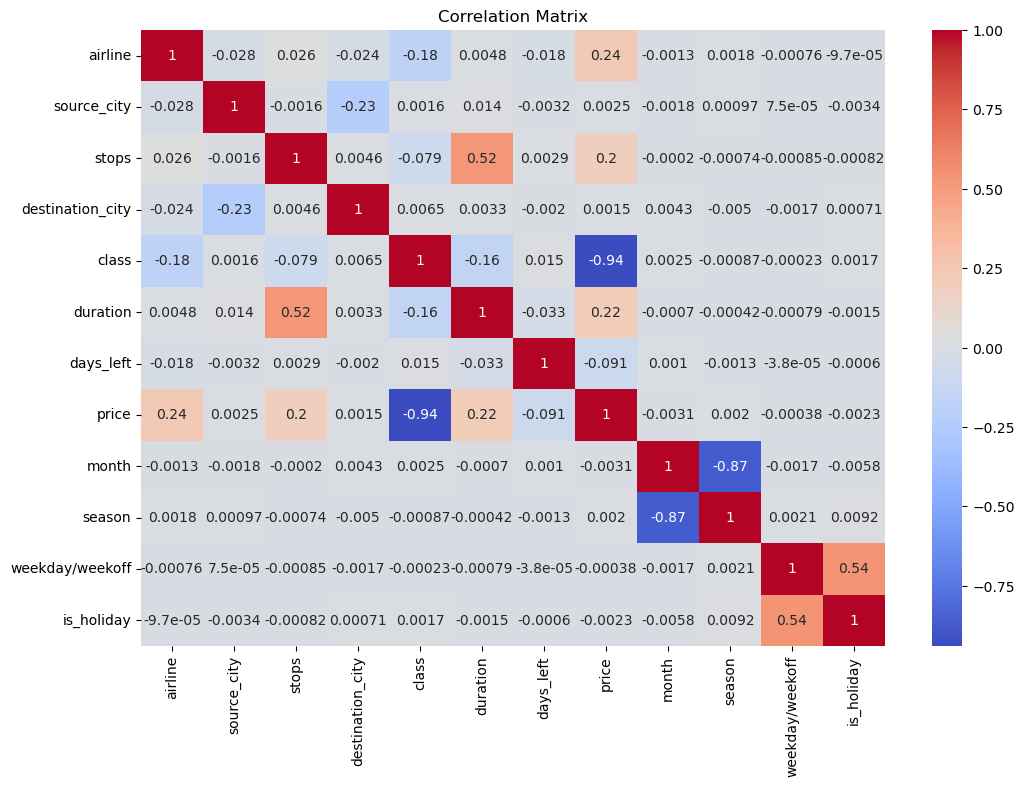

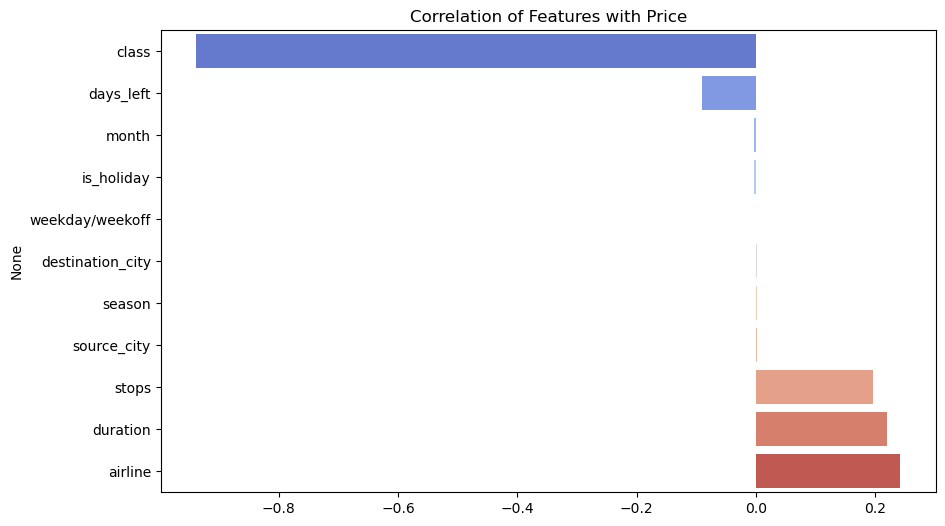

In [10]:
# Step 9: Correlation Analysis
# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Correlation with price
corr_with_price = df.corr(numeric_only=True)['price'].drop('price').sort_values()

plt.figure(figsize=(10,6))
# Add hue=corr_with_price.index and legend=False to avoid warning
sns.barplot(x=corr_with_price.values, y=corr_with_price.index, 
            hue=corr_with_price.index, palette="coolwarm", legend=False)
plt.title("Correlation of Features with Price")
plt.show()


In [11]:
X = df.drop(columns=['price'])
y = df['price']



In [12]:
# 2. Convert datetime columns to numeric (nanoseconds since epoch)
for col in X.select_dtypes(include=['datetime64[ns]']).columns:
    X[col] = X[col].astype(np.int64)  # convert datetime to int64



In [13]:
# 3. Now split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# Select numeric columns except 'price'
X = df.select_dtypes(include=['number']).drop(columns=['price'], errors='ignore')

# Handle missing or infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


             feature        VIF
0            airline   3.762261
1        source_city   3.123721
2              stops  10.264602
3   destination_city   3.187291
4              class   3.056428
5           duration   5.378929
6          days_left   4.394686
7              month   6.742893
8             season   5.522997
9    weekday/weekoff   2.872569
10        is_holiday   1.668905


In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()  # Use =, not -

# Apply label encoding to each categorical column separately
df["airline"] = le.fit_transform(df["airline"])
df["source_city"] = le.fit_transform(df["source_city"])
df["departure_time"] = le.fit_transform(df["departure_time"])
df["stops"] = le.fit_transform(df["stops"])
df["arrival_time"] = le.fit_transform(df["arrival_time"])
df["destination_city"] = le.fit_transform(df["destination_city"])
df["class"] = le.fit_transform(df["class"])

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 286867 entries, 0 to 300152
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   airline           286867 non-null  int64         
 1   source_city       286867 non-null  int64         
 2   departure_time    286867 non-null  int32         
 3   stops             286867 non-null  int64         
 4   arrival_time      286867 non-null  int32         
 5   destination_city  286867 non-null  int64         
 6   class             286867 non-null  int64         
 7   duration          286867 non-null  float64       
 8   days_left         286867 non-null  int64         
 9   price             286867 non-null  int64         
 10  travel_date       286867 non-null  datetime64[ns]
 11  month             286867 non-null  int32         
 12  season            286867 non-null  int32         
 13  weekday/weekoff   286867 non-null  int32         
 14  is_holida

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# Step 1: Define X and y
X = df.drop(columns=['price'])
y = df['price']

# Step 2: Convert datetime columns to int
datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_cols:
    X[col] = X[col].astype(np.int64)

# Step 3: Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Scale features for Linear Regression
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Step 5: Train Linear Regression
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)


In [17]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# R² Score
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

# Mean Absolute Error
mean_abs_error = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mean_abs_error)

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error:", mape)

# Mean Squared Error
mean_sq_error = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mean_sq_error)

# Root Mean Squared Error
root_mean_sq_error = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", root_mean_sq_error)


R² Score: 0.9085614133865725
Mean Absolute Error: 4631.640700446324
Mean Absolute Percentage Error: 0.4583564281481014
Mean Squared Error: 47957571.915533274
Root Mean Squared Error: 6925.140570091937


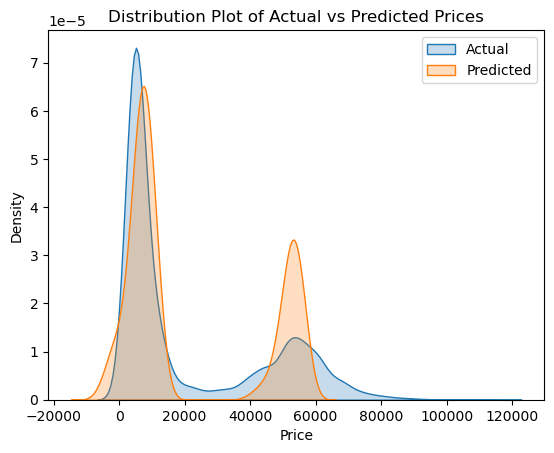

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(y_test, label="Actual", fill=True)
sns.kdeplot(y_pred, label="Predicted", fill=True)

plt.title("Distribution Plot of Actual vs Predicted Prices")
plt.xlabel("Price")
plt.ylabel("Density")
plt.legend()
plt.show()


In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Initialize the model
dt = DecisionTreeRegressor()

# Fit the model
dt.fit(x_train, y_train)

# Predict
y_pred = dt.predict(x_test)

# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

mean_abs_error = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mean_abs_error)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error:", mape)

mean_sq_error = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mean_sq_error)

root_mean_sq_error = np.sqrt(mean_sq_error)
print("Root Mean Squared Error:", root_mean_sq_error)


R2 Score: 0.9738614698937484
Mean Absolute Error: 1337.930142573291
Mean Absolute Percentage Error: 0.09091188567690782
Mean Squared Error: 13709096.824040506
Root Mean Squared Error: 3702.5797525563858


R2 Score: 0.9851161490636027
Mean Absolute Error: 1216.7157038728344
Mean Absolute Percentage Error: 0.0836454832716716
Mean Squared Error: 7806259.677657084
Root Mean Squared Error: 2793.968446073986


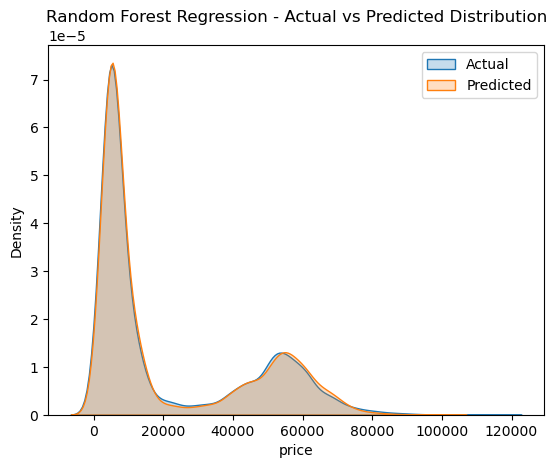

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the model
rfr = RandomForestRegressor()

# Fit the model
rfr.fit(x_train, y_train)

# Predict
y_pred = rfr.predict(x_test)

# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

mean_abs_error = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mean_abs_error)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error:", mape)

mean_sq_error = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mean_sq_error)

root_mean_sq_error = np.sqrt(mean_sq_error)
print("Root Mean Squared Error:", root_mean_sq_error)

# Plot Actual vs Predicted distribution
sns.kdeplot(y_test, label="Actual", fill=True)
sns.kdeplot(y_pred, label="Predicted", fill=True)
plt.legend()
plt.title("Random Forest Regression - Actual vs Predicted Distribution")
plt.show()


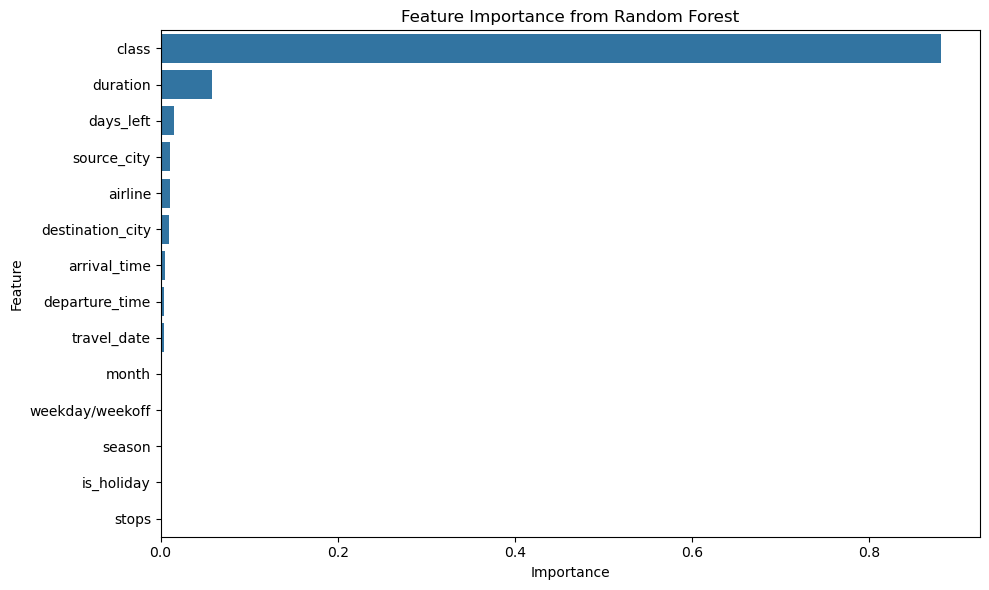

In [21]:


# Assuming you already have a trained RandomForestRegressor model 'rfr'
importances = rfr.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Now plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()



In [33]:

rf_preds = rfr.predict(x_test)

# Assuming y_test and rf_preds are defined
rf_output = pd.DataFrame({
    'Actual Price': y_test.values,    # convert Series to numpy array for consistency
    'Predicted Price': rf_preds       # predicted values from Random Forest
})

rf_output.to_csv('rf_predictions_for_powerbi.csv', index=False)
print("CSV exported for Power BI.")

CSV exported for Power BI.


In [31]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Calculate metrics
mae = mean_absolute_error(y_test, rf_preds)
rmse = root_mean_squared_error(y_test, rf_preds)
r2 = r2_score(y_test, rf_preds)

# Save metrics
metrics_df = pd.DataFrame({
    'MAE': [mae],
    'RMSE': [rmse],
    'R2_Score': [r2]
})

metrics_df.to_excel("rf_model_metrics.xlsx", index=False)
print("✅ Metrics summary exported: rf_model_metrics.xlsx")


✅ Metrics summary exported: rf_model_metrics.xlsx
